## Thesis Code

In [81]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import itertools
import math
import scipy.stats as stats

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size = 14)
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

## Constants

In [82]:
ASSET_NAMES = ['US Equities','Intl. Equities','U.S. Gov. Bonds','Intl. Gov. Bonds']
average_salary = 63795.13 # average salary in 2022 from https://www.ssa.gov/oact/cola/AWI.html
average_salary_growth = 1.022
average_salary_growth_std = 0.005
retirement_age = 67

## All of these functions are allocation strategies

In [83]:
class Allocation(object):
    """Class with static methods to compute asset allocation."""
    equity_ratio = np.array([0.6,0.4,0,0])
    bond_ratio = np.array([0,0,0.7,0.3])
    
    bm_wealth_path = np.load('numpy/bm_path.npy')
    bm_wealth_path_72 = np.load('numpy/bm_path_72.npy')
    
    @classmethod
    def fme(cls,age,aux_dict=None):
        '''Fixed-Mix Equity: 80% Stock, 20% Bond.'''
        return 0.8*cls.equity_ratio + 0.2*cls.bond_ratio

    @classmethod
    def fmb(cls,age,aux_dict=None):
        '''Fixed-Mix Bond: 20% Stock, 80% Bond.'''
        return 0.2*cls.equity_ratio + 0.8*cls.bond_ratio  
    
    @classmethod
    def _vgp_equity_alloc(cls,age,aux_dict=None):
        '''Based on Vanguard target date fund offerings.'''
        retirement_age = aux_dict['retirement_age']

        yrs_to_retirement = retirement_age - age

        # wealth_path = aux_dict['wealth_path']
        # curr_wealth = wealth_path[-1]
        
        if yrs_to_retirement > 25:
            equity_alloc = 0.9
        elif yrs_to_retirement > -7:
            equity_alloc = 0.3 + 0.6 * (yrs_to_retirement + 7)/32    
        else:
            equity_alloc = 0.3

        
            
        return equity_alloc
    
    @classmethod
    def sgp(cls,age,aux_dict=None):
        '''Standard Glide Path: Based on Vanguard target date fund offerings.'''            
        equity_alloc = Allocation._vgp_equity_alloc(age, aux_dict)

        bond_alloc = 1 - equity_alloc

        if equity_alloc < 0:
            equity_alloc = 0
            bond_alloc = 1
        
        allocation = equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio
        
        return allocation
    
    @classmethod
    def rgp(cls,age,aux_dict=None):
        '''Reverse Glide Path: Based on Vanguard target date fund offerings.'''
        retirement_age = aux_dict['retirement_age']

        yrs_to_retirement = retirement_age - age
        
        if yrs_to_retirement > 25:
            equity_alloc = 0.3
        elif yrs_to_retirement > -7:
            equity_alloc = 0.3 + 0.6 * (25 - yrs_to_retirement)/32    
        else:
            equity_alloc = 0.9
        
        bond_alloc = 1 - equity_alloc
        
        return equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio
    
    @classmethod
    def cgp(cls,age,aux_dict=None):
        '''Catch-up If fall behind, tilt towards more equity.'''
        wealth_path = aux_dict['wealth_path']
        curr_wealth = wealth_path[-1]
        
        if len(wealth_path) > 1:
            wealth_median = cls.bm_wealth_path[len(wealth_path) - 1]
            
            if curr_wealth > wealth_median:
                return Allocation.sgp(age, aux_dict)
            else:
                equity_alloc = Allocation._vgp_equity_alloc(age, aux_dict)
                equity_alloc = min(1, equity_alloc + 0.2)
                bond_alloc = 1 - equity_alloc
                return equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio
        return Allocation.sgp(age,aux_dict)

    @classmethod
    def cgp_70(cls,age,aux_dict=None):
        '''Dynamic strategy. If fall behind, tilt towards more equity.'''
        wealth_path = aux_dict['wealth_path']
        curr_wealth = wealth_path[-1]
        
        if len(wealth_path) > 1:
            wealth_median = cls.bm_wealth_path_70[len(wealth_path) - 1]
            
            if curr_wealth > wealth_median:
                return Allocation.sgp(age, aux_dict)
            else:
                equity_alloc = Allocation._vgp_equity_alloc(age, aux_dict)
                equity_alloc = min(1, equity_alloc + 0.2)
                bond_alloc = 1 - equity_alloc
                return equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio
        return Allocation.sgp(age,aux_dict)

    """
    @classmethod
    def pgp(cls, age, aux_dict=None):
        '''Play-safe dynamic s trategy. If rise ahead, tilt towards more bond.'''
        wealth_path = aux_dict['wealth_path']
        curr_wealth = wealth_path[-1]

        if aux_dict is None:
            raise ValueError("aux_dict is required but was None.")
        if 'wealth_path' not in aux_dict:
            raise KeyError("'wealth_path' key is missing in aux_dict.")

        if len(wealth_path) > 1:
            # Assume 'bm_wealth_path' is the benchmark
            wealth_median = cls.bm_wealth_path[len(wealth_path) - 1]

            # If current wealth is ahead of the benchmark
            if curr_wealth > wealth_median:
                # Decrease equity allocation to play it safe
                equity_alloc = Allocation._vgp_equity_alloc(age, aux_dict)
                # Decreasing the equity allocation by a certain factor, e.g., 0.2
                equity_alloc = max(0, equity_alloc - 0.2)
                bond_alloc = 1 - equity_alloc
                return equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio
            else:
                # If not ahead, follow the standard glide path
                return Allocation.sgp(age, aux_dict)

        # Default to standard glide path if wealth path length is 1 or less
        return Allocation.sgp(age, aux_dict)
    """

    @classmethod
    def pgp(cls,age,aux_dict=None):
        '''Dynamic strategy. If fall behind, tilt towards more equity.'''
        wealth_path = aux_dict['wealth_path']
        curr_wealth = wealth_path[-1]
        
        if len(wealth_path) > 1:
            wealth_median = cls.bm_wealth_path[len(wealth_path) - 1]
            
            if curr_wealth > wealth_median:
                return Allocation.sgp(age, aux_dict)
            else:
                equity_alloc = Allocation._vgp_equity_alloc(age, aux_dict)
                equity_alloc = min(1, equity_alloc + 0.2)
                bond_alloc = 1 - equity_alloc
                return equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio
        return Allocation.sgp(age,aux_dict)
    
    @classmethod
    def dzgp(cls, age, aux_dict=None):
        '''Dynamic-Zone Glide Path combines the behaviors of both CGP and 
        PGP by overlaying an equity tilt when falling behind the benchmark 
        wealth path and overlaying a bond tilt when exceeding the benchmark wealth path.'''
        wealth_path = aux_dict['wealth_path']
        curr_wealth = wealth_path[-1]

        if len(wealth_path) > 1:
            wealth_median = cls.bm_wealth_path[len(wealth_path) - 1]

            equity_alloc = Allocation._vgp_equity_alloc(age, aux_dict)

            # If current wealth is behind the benchmark, increase equity allocation
            if curr_wealth < wealth_median:
                equity_alloc = min(1, equity_alloc + 0.2)  # increase equity by a factor, e.g., 0.2
            # If current wealth is ahead of the benchmark, decrease equity allocation
            elif curr_wealth > wealth_median:
                equity_alloc = max(0, equity_alloc - 0.2)  # decrease equity by a factor, e.g., 0.2

            bond_alloc = 1 - equity_alloc
            return equity_alloc * cls.equity_ratio + bond_alloc * cls.bond_ratio

        # Default to standard glide path if wealth path length is 1 or less
        return Allocation.sgp(age, aux_dict)



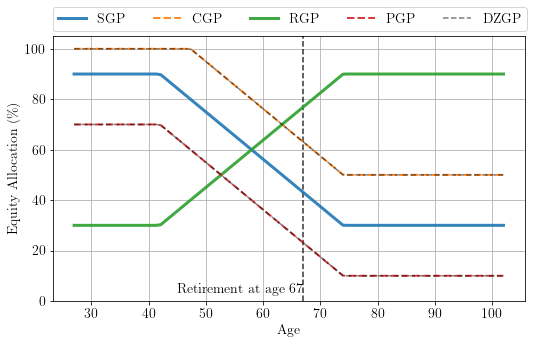

In [84]:
xs = np.linspace(27,102,100)
retirement_age = 67
dictionary = {'retirement_age': retirement_age}
ys_sgp = np.array([np.sum(100*Allocation.sgp(x,dictionary)[:2]) for x in xs])
ys_rgp = np.array([np.sum(100*Allocation.rgp(x,dictionary)[:2]) for x in xs])
ys_fme = np.array([np.sum(100*Allocation.fme(x,dictionary)[:2]) for x in xs])
ys_fmb = np.array([np.sum(100*Allocation.fmb(x,dictionary)[:2]) for x in xs])
ys_cgp_limit = [ min(100, y + 20) for y in ys_sgp]

ys_pgp_limit = [ min(100, y - 20) for y in ys_sgp]


fig = plt.figure(figsize=(8,5))
lwidth = 2


plt.axvline(x=retirement_age,linestyle='--',color='k',alpha=0.8)
plt.text(retirement_age - 22, 3, 'Retirement at age ' + str(retirement_age))

plt.plot(xs, ys_sgp,label='SGP',linewidth=lwidth+1,alpha=0.9)
plt.plot(xs, ys_cgp_limit,label='CGP',linestyle='--',linewidth=lwidth,alpha=0.9)
# plt.plot(xs, ys_sgp,color='orange',linestyle='--',linewidth=lwidth,alpha=0.9)
plt.plot(xs, ys_rgp,label='RGP',linewidth=lwidth+1,alpha=0.9)
# plt.plot(xs, ys_fme,label='FME',linewidth=lwidth+1,alpha=0.9)
# plt.plot(xs, ys_fmb,label='FMB',linewidth=lwidth+1,alpha=0.9)


plt.plot(xs, ys_pgp_limit,label='PGP', linestyle='--',linewidth=lwidth,alpha=0.9)
# plt.plot(xs, ys_sgp,color='brown', linestyle='--',linewidth=lwidth,alpha=0.5)

# 
#plt.plot(xs, ys_cgp_limit,color='orange',linestyle='--',linewidth=lwidth,alpha=0.9)

plt.plot(xs, ys_pgp_limit,label='DZGP', color='black',linestyle='--',linewidth=lwidth-0.5,alpha=0.5)
plt.plot(xs, ys_cgp_limit,color='black', linestyle='--',linewidth=lwidth-0.5,alpha=0.5)


plt.ylim(0,105)
# plt.title('Asset Allocation Strategies',y=1.14)
plt.xlabel('Age')
plt.ylabel('Equity Allocation (\%)')
plt.grid()

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                borderaxespad=0, ncol=5)
plt.tight_layout()

plt.savefig('fig_asset_allocation_strategies_all',dpi=300)
plt.show()

## SGP

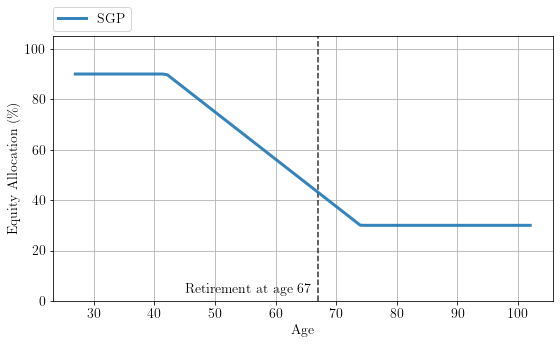

In [85]:
xs = np.linspace(27,102,100)
retirement_age = 67
dictionary = {'retirement_age': retirement_age}
ys_sgp = np.array([np.sum(100*Allocation.sgp(x,dictionary)[:2]) for x in xs])
ys_rgp = np.array([np.sum(100*Allocation.rgp(x,dictionary)[:2]) for x in xs])
ys_cgp_limit = [ min(100, y + 20) for y in ys_sgp]

ys_pgp_limit = [ min(100, y - 20) for y in ys_sgp]


fig = plt.figure(figsize=(8,5))
lwidth = 2


plt.axvline(x=retirement_age,linestyle='--',color='k',alpha=0.8)
plt.text(retirement_age - 22, 3, 'Retirement at age ' + str(retirement_age))

plt.plot(xs, ys_sgp,label='SGP',linewidth=lwidth+1,alpha=0.9)

plt.ylim(0,105)
# plt.title('Asset Allocation Strategies',y=1.14)
plt.xlabel('Age')
plt.ylabel('Equity Allocation (\%)')
plt.grid()

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                borderaxespad=0, ncol=5)
plt.tight_layout()

plt.savefig('fig_asset_allocation_strategies_sgp',dpi=300)
plt.show()

## CGP

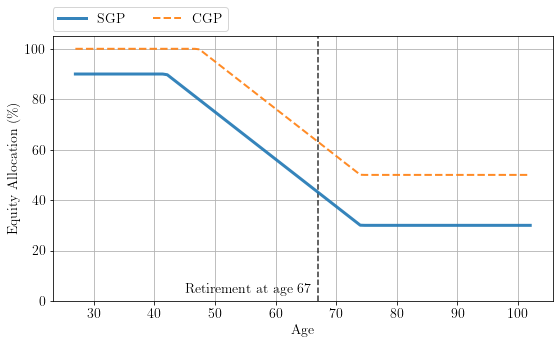

In [86]:
xs = np.linspace(27,102,100)
retirement_age = 67
dictionary = {'retirement_age': retirement_age}
ys_sgp = np.array([np.sum(100*Allocation.sgp(x,dictionary)[:2]) for x in xs])
ys_rgp = np.array([np.sum(100*Allocation.rgp(x,dictionary)[:2]) for x in xs])
ys_cgp_limit = [ min(100, y + 20) for y in ys_sgp]

ys_pgp_limit = [ min(100, y - 20) for y in ys_sgp]


fig = plt.figure(figsize=(8,5))
lwidth = 2


plt.axvline(x=retirement_age,linestyle='--',color='k',alpha=0.8)
plt.text(retirement_age - 22, 3, 'Retirement at age ' + str(retirement_age))

plt.plot(xs, ys_sgp,label='SGP',linewidth=lwidth+1,alpha=0.9)
plt.plot(xs, ys_cgp_limit,label='CGP',linestyle='--',linewidth=lwidth,alpha=0.9)


plt.ylim(0,105)
# plt.title('Asset Allocation Strategies',y=1.14)
plt.xlabel('Age')
plt.ylabel('Equity Allocation (\%)')
plt.grid()

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                borderaxespad=0, ncol=5)
plt.tight_layout()

plt.savefig('fig_asset_allocation_strategies_cgp',dpi=300)
plt.show()

## PGP

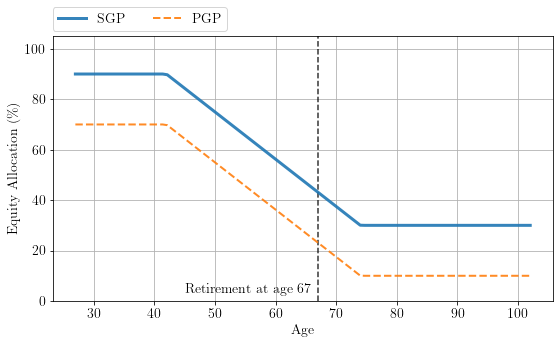

In [87]:
xs = np.linspace(27,102,100)
retirement_age = 67
dictionary = {'retirement_age': retirement_age}
ys_sgp = np.array([np.sum(100*Allocation.sgp(x,dictionary)[:2]) for x in xs])
ys_rgp = np.array([np.sum(100*Allocation.rgp(x,dictionary)[:2]) for x in xs])
ys_cgp_limit = [ min(100, y + 20) for y in ys_sgp]

ys_pgp_limit = [ min(100, y - 20) for y in ys_sgp]


fig = plt.figure(figsize=(8,5))
lwidth = 2


plt.axvline(x=retirement_age,linestyle='--',color='k',alpha=0.8)
plt.text(retirement_age - 22, 3, 'Retirement at age ' + str(retirement_age))

plt.plot(xs, ys_sgp,label='SGP',linewidth=lwidth+1,alpha=0.9)


plt.plot(xs, ys_pgp_limit,label='PGP', linestyle='--',linewidth=lwidth,alpha=0.9)


plt.ylim(0,105)
# plt.title('Asset Allocation Strategies',y=1.14)
plt.xlabel('Age')
plt.ylabel('Equity Allocation (\%)')
plt.grid()

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                borderaxespad=0, ncol=5)
plt.tight_layout()

plt.savefig('fig_asset_allocation_strategies_pgp',dpi=300)
plt.show()

## DZGP

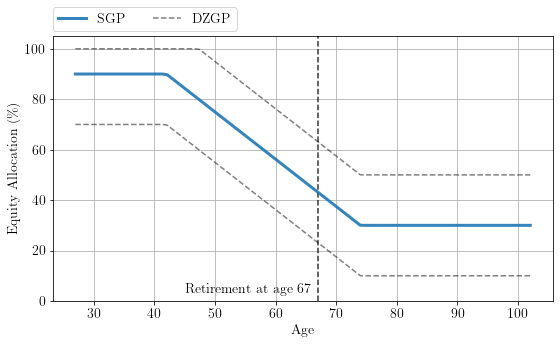

In [88]:
xs = np.linspace(27,102,100)
retirement_age = 67
dictionary = {'retirement_age': retirement_age}
ys_sgp = np.array([np.sum(100*Allocation.sgp(x,dictionary)[:2]) for x in xs])
ys_rgp = np.array([np.sum(100*Allocation.rgp(x,dictionary)[:2]) for x in xs])
ys_cgp_limit = [ min(100, y + 20) for y in ys_sgp]

ys_pgp_limit = [ min(100, y - 20) for y in ys_sgp]


fig = plt.figure(figsize=(8,5))
lwidth = 2


plt.axvline(x=retirement_age,linestyle='--',color='k',alpha=0.8)
plt.text(retirement_age - 22, 3, 'Retirement at age ' + str(retirement_age))

plt.plot(xs, ys_sgp,label='SGP',linewidth=lwidth+1,alpha=0.9)

plt.plot(xs, ys_pgp_limit,label='DZGP', color='black',linestyle='--',linewidth=lwidth-0.5,alpha=0.5)
plt.plot(xs, ys_cgp_limit,color='black', linestyle='--',linewidth=lwidth-0.5,alpha=0.5)


plt.ylim(0,105)
# plt.title('Asset Allocation Strategies',y=1.14)
plt.xlabel('Age')
plt.ylabel('Equity Allocation (\%)')
plt.grid()

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                borderaxespad=0, ncol=5)
plt.tight_layout()

plt.savefig('fig_asset_allocation_strategies_dzgp',dpi=300)
plt.show()

## RGP

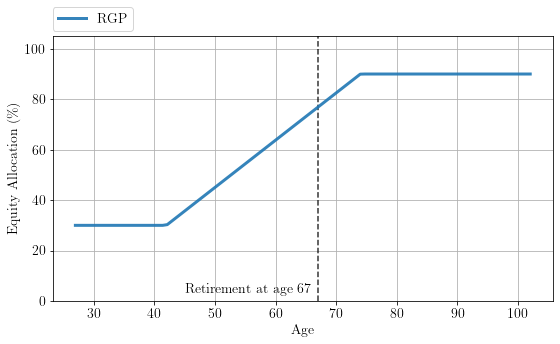

In [89]:
xs = np.linspace(27,102,100)
retirement_age = 67
dictionary = {'retirement_age': retirement_age}
ys_sgp = np.array([np.sum(100*Allocation.sgp(x,dictionary)[:2]) for x in xs])
ys_rgp = np.array([np.sum(100*Allocation.rgp(x,dictionary)[:2]) for x in xs])
ys_fme = np.array([np.sum(100*Allocation.fme(x,dictionary)[:2]) for x in xs])
ys_fmb = np.array([np.sum(100*Allocation.fmb(x,dictionary)[:2]) for x in xs])
ys_cgp_limit = [ min(100, y + 20) for y in ys_sgp]

ys_pgp_limit = [ min(100, y - 20) for y in ys_sgp]


fig = plt.figure(figsize=(8,5))
lwidth = 2


plt.axvline(x=retirement_age,linestyle='--',color='k',alpha=0.8)
plt.text(retirement_age - 22, 3, 'Retirement at age ' + str(retirement_age))

plt.plot(xs, ys_rgp,label='RGP',linewidth=lwidth+1,alpha=0.9)

plt.ylim(0,105)
# plt.title('Asset Allocation Strategies',y=1.14)
plt.xlabel('Age')
plt.ylabel('Equity Allocation (\%)')
plt.grid()

plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                borderaxespad=0, ncol=5)
plt.tight_layout()

plt.savefig('fig_asset_allocation_strategies_rgp',dpi=300)
plt.show()

## All these functions are for plotting

In [90]:
class Plotting(object):
    """Class with static methods to plot results."""

    @classmethod 
    def _plot_scenarios(cls, xs, list_mtx_values, list_names, 
                        pctile_dotted=None, pctile_fill=49, figsize=(10,5),
                        title='Default Title',xlabel='X Values',ylabel='Y Values'):
        plt.figure(figsize=(10,5))

        for mtx_values, name in zip(list_mtx_values, list_names):
            # plot the median
            y_med = Port.calc_stat(mtx_values, lambda x: np.percentile(x, 50)) 
            a = plt.plot(xs,y_med,label=name)

            # plot the dotted lines
            if pctile_dotted != None:
                y_dotted_lower = Port.calc_stat(mtx_values, lambda x: np.percentile(x, 50-pctile_dotted))
                y_dotted_upper = Port.calc_stat(mtx_values, lambda x: np.percentile(x, 50+pctile_dotted))
                plt.plot(xs,y_dotted_lower,linestyle='--',color=a[0].get_color())
                plt.plot(xs,y_dotted_upper,linestyle='--',color=a[0].get_color())

            # plot the fill
            alpha=0.25
            y_fill_lower = Port.calc_stat(mtx_values, lambda x: np.percentile(x, 50-pctile_fill))
            y_fill_upper = Port.calc_stat(mtx_values, lambda x: np.percentile(x, 50+pctile_fill))
            plt.fill_between(xs, y_fill_lower, y_fill_upper,color=a[0].get_color(),interpolate=True,alpha=alpha)
        
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()
        
    @classmethod
    def wealth_path(cls,list_ports, list_names,num_periods,
                    pctile_dotted = None, pctile_fill=49,figsize=(10,5)):
        xs = [25 + x/12 for x in range(num_periods)]
        title = 'Wealth over time'
        ylabel = 'Wealth'
        xlabel = 'Age'
        
        list_port_wealth = [port.wealth_path() for port in list_ports]
        Plotting._plot_scenarios(xs, list_port_wealth, list_names, 
                                 pctile_dotted=pctile_dotted, pctile_fill=pctile_fill,
                                 figsize=figsize, title=title, ylabel=ylabel,xlabel=xlabel)
        
    @classmethod
    def relative_dd_path(cls,list_ports, list_names, num_periods, pctile_dotted = None, 
                         pctile_fill=49, figsize=(10,5)):
        xs = [25 + x/12 for x in range(num_periods)]
        title = 'Drawdown over time'
        ylabel = 'Drawdown'
        xlabel = 'Age'
        
        list_port_dd = [port.dd_path() for port in list_ports]
        Plotting._plot_scenarios(xs, list_port_dd, list_names, 
                                 pctile_dotted=pctile_dotted, pctile_fill=pctile_fill,
                                 figsize=figsize,title=title, ylabel=ylabel,xlabel=xlabel,)
        
    @classmethod    
    def prob_dd_path(cls,list_ports, list_names,num_periods,figsize=(10,5)):
        xs = [25 + x/12 for x in range(num_periods)]
        title = 'Probability Drawdown over time'
        ylabel = 'Probability in Drawdown'
        xlabel = 'Age'
        
        plt.figure(figsize=figsize)
        
        list_prob_dd_path = [port.prob_dd_path() for port in list_ports]
        
        for prob_dd_path, name in zip(list_prob_dd_path,list_names):
            plt.plot(xs, prob_dd_path, label=name)
            
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

    @classmethod    
    def prob_success(cls,list_ports, list_names,start_age,end_age,figsize=(9,6),title_extra=None,file_name=None):
        xs = range(start_age, end_age + 1)
        title = 'Performance of Asset Allocation Strategies Post-Retirement'
        if title_extra != None:
            title = title + '\n' + title_extra
        ylabel = 'Probability of a Portfolio\nWith Positive Wealth'
        xlabel = 'Age'
        
        plt.figure(figsize=figsize)
        
        list_prob_success = []
        for port in list_ports:
            list_prob_success.append([port.prob_success(age) for age in xs])
        
        for prob_success, name in zip(list_prob_success,list_names):
            plt.plot(xs, prob_success,alpha=0.8, linewidth=2,label=name)
            
        plt.title(title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(loc='lower left')
        plt.grid(True)
        plt.tight_layout()
        
        if file_name != None:
            plt.savefig(file_name,dpi=300)
            
        plt.show()
        
    @classmethod
    def cdf_at_period(cls,list_ports,list_names,index_period = -1,title='',figsize=(10,5)):
        plt.figure(figsize=figsize)
        lower_limit = math.inf
        upper_limit = -math.inf
        
        for port in list_ports:
            port_wealth = port.wealth_path()
            lower_limit = min(lower_limit, np.amin(port_wealth[:,index_period]))
            upper_limit = max(upper_limit, np.amax(port_wealth[:,index_period]))
        
        for port, name in zip(list_ports, list_names):
            x,arr_Fofx = port.ecdf(t=index_period,lower_limit=lower_limit, upper_limit=upper_limit)
            plt.plot(x,arr_Fofx,label=name)

        plt.title('Empirical CDF of Wealth at Age ' + title)
        plt.ylabel('Cumulative Probability')
        plt.xlabel('Wealth')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
        
    @classmethod
    def hist_returns(cls,list_arr_returns, list_names):
        '''Plot histogram of returns for every period. Compare different distributions
        
        Args:
            list_arr_returns: 
            list_name: 
        
        Returns:
        '''
        for arr_returns, name in zip(list_arr_returns, list_names):

            # the histogram of the data
            alpha = 0.5
            plt.hist(arr_returns, bins='auto', density=True, alpha=alpha,label=name)
            
        plt.xlabel('Return')
        plt.ylabel('Probability')
        plt.title('Histogram')
        plt.grid(True)
        plt.legend()
        plt.show()

## Object for Portfolios

In [91]:
class Port:
    def __init__(self, descr, starting_age, retirement_age, f_alloc, f_contr, mtx_returns):
        # string descriptor for portfolio
        self.descr = descr

        # starting age
        self.starting_age = starting_age
        
        # function to determine asset allocation
        self.f_alloc = f_alloc

        # function to determine contribution
        self.f_contr = f_contr
        
        # scenario results to use in simulation
        self.mtx_returns = mtx_returns
        self.num_scenarios, self.num_periods, self.num_assets = mtx_returns.shape
        
        # the wealth is at the end of the i-th period
        # add extra period because will have wealth at start of 0th period
        self.port_wealth = np.empty((self.num_scenarios, self.num_periods + 1, self.num_assets))
        
        # portfolio allocation
        self.port_alloc = np.empty_like(mtx_returns)
        
        # age where money runs out
        self.array_failure_age = np.empty(self.num_scenarios)
        
        self.retirement_age = retirement_age
    
    def _rebalance(self, s, t, target_weights):
        """Rebalance a portfolio to specified asset allocation

        Args:
            assets: Numpy array of dimension (num_assets) that is wealth in each 
                asset
            target_weights: Numpy array of dimension (num_assets) for target 
                proportion invested in each asset

        Returns:
            Numpy array with dimension (num_scenarios, num_periods, 
                num_assets)
        """
        if np.round(np.sum(target_weights),4) != 1:
            raise ValueError('target_weights must sum to 1. You have' % 
                             np.sum(target_weights))
        target_weights = target_weights / np.sum(target_weights)
        total_wealth = np.sum(self.port_wealth[s,t,:])
        self.port_wealth[s,t] = total_wealth * target_weights

    def simulate(self):
        """Simulate a wealth path for an individual

        Returns:
            Numpy array with dimension (scenarios, periods, assets)
        """
        # print status
        print('Simulating wealth path for %s...' % self.descr)
 
        for s in range(self.num_scenarios):
            initial_wealth = 1
            self.port_wealth[s,0,:] = np.ones(self.num_assets) * initial_wealth/self.num_assets
    
            salary = average_salary
            
            for t in range(1,self.num_periods+1):
                # calculate portfolio returns
                self.port_wealth[s,t,:] = np.multiply(1 + self.mtx_returns[s,t-1,:], self.port_wealth[s,t-1,:])
                
                age = self.starting_age + t / 12
                    
                # add savings to portfolio - add to first asset, will rebalance
                if t%12 == 0:
                    # set seed to be identical across different simulations
                    np.random.seed(s*t)
                    
                    salary *= np.random.normal(average_salary_growth, average_salary_growth_std)
                        
                if age < self.retirement_age:
                    self.port_wealth[s,t,0] += salary/12 * self.f_contr(t)
                    
                # we are in retirement
                else:
                    # scale salary by inflation of 1.022%
                    # the below line isn't working for some reason
                    # salary *= 1.022

                    # subtract because we are spending now, monthly spend
                    self.port_wealth[s,t,0] -= salary/12 * 0.7
                    

                # if less than zero, then just set rest to zero and mark failure
                if np.sum(self.port_wealth[s,t,:]) < 0:
                    self.port_wealth[s,t:,:] = 0
                    self.array_failure_age[s] = age
                    break
                    
                # rebalance portfolio
                aux_dict = {'wealth_path': np.sum(self.port_wealth[s,1:t+1,:], axis=1),
                            'retirement_age': self.retirement_age }
                self.port_alloc[s,t-1,:] = self.f_alloc(age,aux_dict=aux_dict)
                self._rebalance(s, t, self.port_alloc[s,t-1,:])

            self.array_failure_age[s] = age
            
        print('Done!')
        
    
    def wealth_path(self):
        """Wealth for each scenario at each point in time.
            
        Returns:
            Numpy array of dimension (scenarios, periods) where each value is 
            wealth
        """
        # total wealth for each period is sum of all asset holdings for that period
        mtx_wealth_total = np.sum(self.port_wealth, axis = 2)
        
        # don't include first element of array, which represents the -1th period
        return(mtx_wealth_total[:,1:])
    
    def dd_path(self, relative_dd = True):
        """Calculate drawdown

        Args:
            relative_dd: Boolean to determine if relative or absolute drawdown
            
        Returns:
            Numpy array of dimension (scenarios, periods) where each value is now
            the drawdown
        """
        port_drawdown = np.empty((self.num_scenarios, self.num_periods))
        port_wealth_path = self.wealth_path()
        for s in range(self.num_scenarios):
            for t in range(self.num_periods):
                max_wealth = np.amax(port_wealth_path[s,:t+1])
                port_drawdown[s,t] = max(0, max_wealth - port_wealth_path[s,t])
                
                # if relative drawdown, divide by the max wealth attained
                if relative_dd:
                    port_drawdown[s,t] /= max_wealth
                
        return(port_drawdown)
    
    def prob_success(self, age):
        """Calculate probability of success at given age

        """
        if age < self.retirement_age:
            return -1
        
        return np.mean(self.array_failure_age >= age)
    
    def prob_dd_path(self):
        """Calculate probability that you are in drawdown

        Args:
            relative_dd: Boolean to determine if relative or absolute drawdown
            
        Returns:
            Numpy array of dimension (periods) where each value is probability
            you are in drawdown at that period
        """
        dd_path = self.dd_path()
        dd_path_bool = dd_path > 0
        prob_dd_path = np.mean(dd_path_bool, axis = 0)
        return(prob_dd_path)
    
    def _helper_cdf(self, arr_x, arr_samples):
        '''Generate empirical CDF from array of observation
        
        Args:
            arr_x: Numpy array of points to sample the empirical CDF from.
            arr_samples: emperical distribution
        
        Returns:
            Two numpy arrays for (x,F_of_x) points to plot the CDF
        '''
        total = arr_samples.shape[0]
        arr_Fofx = np.array([(arr_samples < x).sum() / total for x in arr_x])        
        return((arr_x,arr_Fofx))
    
    def ecdf(self, t=-1, lower_limit=None, upper_limit=None):
        '''Get empricial CDF'''
        port_wealth = self.wealth_path()
        if (lower_limit == None) and (upper_limit == None):
            lower_limit = np.amin(port_wealth[:,t])
            upper_limit = np.amax(port_wealth[:,t])
            
        num_points = 1000
        x,arr_Fofx = self._helper_cdf(np.linspace(lower_limit,upper_limit,num_points), port_wealth[:,t])
        
        return (x, arr_Fofx)
    
    @classmethod
    def calc_stat(cls, mtx_values, f_statistic):
        """Calculate scenario based statistic for series of wealth values for each period

        Args:
            f_statistic: Function that takes as input Numpy array of dimension (scenarios)
                and returns a single summary statistic
                
        Returns:
            Numpy array of dimension (periods) where each value is the calculated statistic
        """
        return(np.apply_along_axis(f_statistic, axis=0, arr=mtx_values))
    

## Loading Return Scenarios

In [92]:
n_years = 75
n_assets = 4
n_sim = 1000

# dimensions are: scenarios x time periods x assets
mtx_returns_low = np.load('numpy/mtx_returns_low.npy')
mtx_returns_baseline = np.load('numpy/mtx_returns_baseline.npy')
mtx_returns_high = np.load('numpy/mtx_returns_high.npy')
mtx_returns_test = np.load('numpy/mtx_returns_test.npy')
print(mtx_returns_test.shape)
print(mtx_returns_baseline.shape)

(10, 900, 4)
(1000, 900, 4)


## All of these functions are Savings Strategies

In [93]:
def saving_pct_strat(t):
    return 0.15

## Running Experiments: Strategy Testing

### Testing

In [94]:
port_cgp_test = Port('CGP test',27,67, Allocation.cgp, saving_pct_strat, mtx_returns_test)
port_cgp_test.simulate()

Simulating wealth path for CGP test...
Done!


### LTCMA: Baseline, Retirement Age: 67

In [95]:
port_sgp = Port('SGP_{B,67}',27,67, Allocation.sgp, saving_pct_strat, mtx_returns_baseline)
port_sgp.simulate()
port_cgp = Port('CGP_{B,67}',27,67, Allocation.cgp, saving_pct_strat, mtx_returns_baseline)
port_cgp.simulate()
port_rgp = Port('RGP_{B,67}', 27,67, Allocation.rgp, saving_pct_strat, mtx_returns_baseline)
port_rgp.simulate()
port_fmb = Port('FMB_{B,67}', 27,67,Allocation.fmb, saving_pct_strat, mtx_returns_baseline)
port_fmb.simulate()
port_fme = Port('FME_{B,67}', 27,67,Allocation.fme, saving_pct_strat, mtx_returns_baseline)
port_fme.simulate()
port_pgp = Port('PGP_{B,67}', 27,67,Allocation.pgp, saving_pct_strat, mtx_returns_baseline)
port_pgp.simulate()
port_dzgp = Port('DZGP_{B,67}', 27,67,Allocation.dzgp, saving_pct_strat, mtx_returns_baseline)
port_dzgp.simulate()

Simulating wealth path for SGP_{B,67}...
Done!
Simulating wealth path for CGP_{B,67}...
Done!
Simulating wealth path for RGP_{B,67}...
Done!
Simulating wealth path for FMB_{B,67}...
Done!
Simulating wealth path for FME_{B,67}...
Done!
Simulating wealth path for PGP_{B,67}...
Done!
Simulating wealth path for DZGP_{B,67}...
Done!


### LTCMA: Baseline, Retirement Age: 67

In [96]:
port_sgp_low = Port('SGP_{B,67}',27,67, Allocation.sgp, saving_pct_strat, mtx_returns_low)
port_sgp_low.simulate()
port_cgp_low = Port('CGP_{B,67}',27,67, Allocation.cgp, saving_pct_strat, mtx_returns_low)
port_cgp_low.simulate()
port_rgp_low = Port('RGP_{B,67}', 27,67, Allocation.rgp, saving_pct_strat, mtx_returns_low)
port_rgp_low.simulate()
# port_fmb_low = Port('FMB_{B,67}', 27,67,Allocation.fmb, saving_pct_strat, mtx_returns_low)
# port_fmb_low.simulate()
# port_fme_low = Port('FME_{B,67}', 27,67,Allocation.fme, saving_pct_strat, mtx_returns_low)
# port_fme_low.simulate()
port_pgp_low = Port('PGP_{B,67}', 27,67,Allocation.pgp, saving_pct_strat, mtx_returns_low)
port_pgp_low.simulate()
port_dzgp_low = Port('DZGP_{B,67}', 27,67,Allocation.dzgp, saving_pct_strat, mtx_returns_low)
port_dzgp_low.simulate()

Simulating wealth path for SGP_{B,67}...
Done!
Simulating wealth path for CGP_{B,67}...
Done!
Simulating wealth path for RGP_{B,67}...
Done!
Simulating wealth path for PGP_{B,67}...
Done!
Simulating wealth path for DZGP_{B,67}...
Done!


In [97]:
port_sgp_high = Port('SGP_{B,67}',27,67, Allocation.sgp, saving_pct_strat, mtx_returns_high)
port_sgp_high.simulate()
port_cgp_high = Port('CGP_{B,67}',27,67, Allocation.cgp, saving_pct_strat, mtx_returns_high)
port_cgp_high.simulate()
port_rgp_high = Port('RGP_{B,67}', 27,67, Allocation.rgp, saving_pct_strat, mtx_returns_high)
port_rgp_high.simulate()
# port_fmb_low = Port('FMB_{B,67}', 27,67,Allocation.fmb, saving_pct_strat, mtx_returns_low)
# port_fmb_low.simulate()
# port_fme_low = Port('FME_{B,67}', 27,67,Allocation.fme, saving_pct_strat, mtx_returns_low)
# port_fme_low.simulate()
port_pgp_high = Port('PGP_{B,67}', 27,67,Allocation.pgp, saving_pct_strat, mtx_returns_high)
port_pgp_high.simulate()
port_dzgp_high = Port('DZGP_{B,67}', 27,67,Allocation.dzgp, saving_pct_strat, mtx_returns_high)
port_dzgp_high.simulate()

Simulating wealth path for SGP_{B,67}...
Done!
Simulating wealth path for CGP_{B,67}...
Done!
Simulating wealth path for RGP_{B,67}...
Done!
Simulating wealth path for PGP_{B,67}...
Done!
Simulating wealth path for DZGP_{B,67}...
Done!


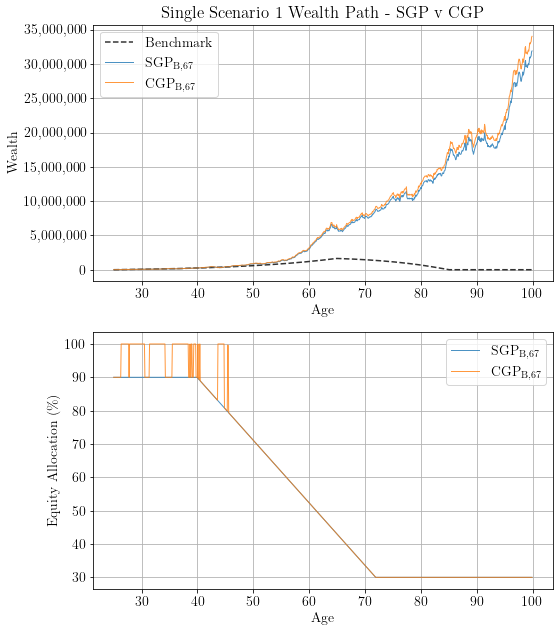

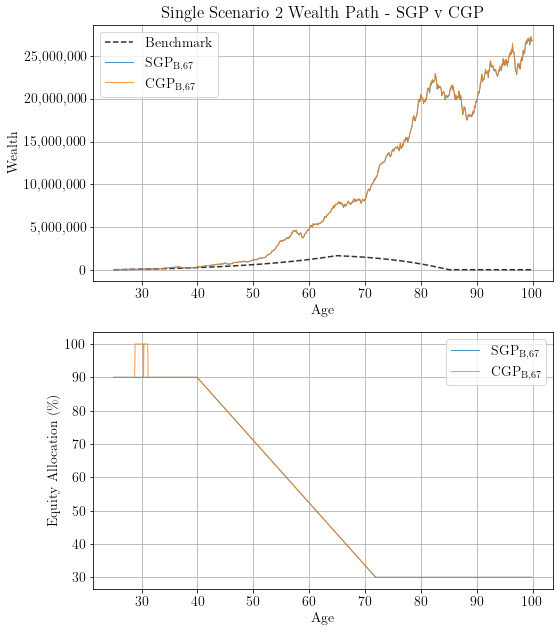

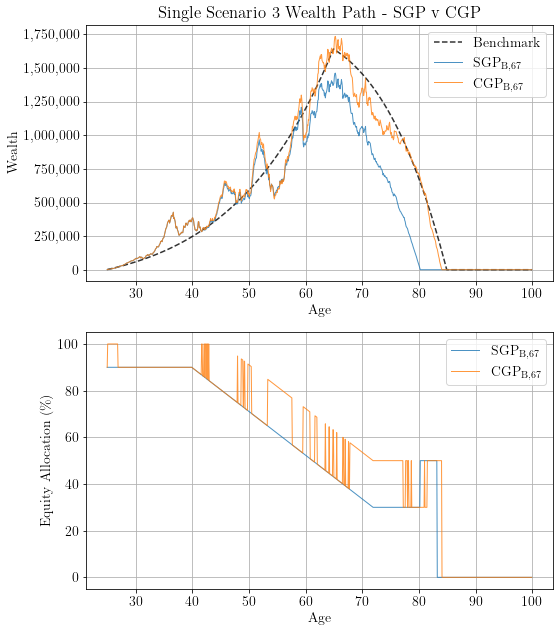

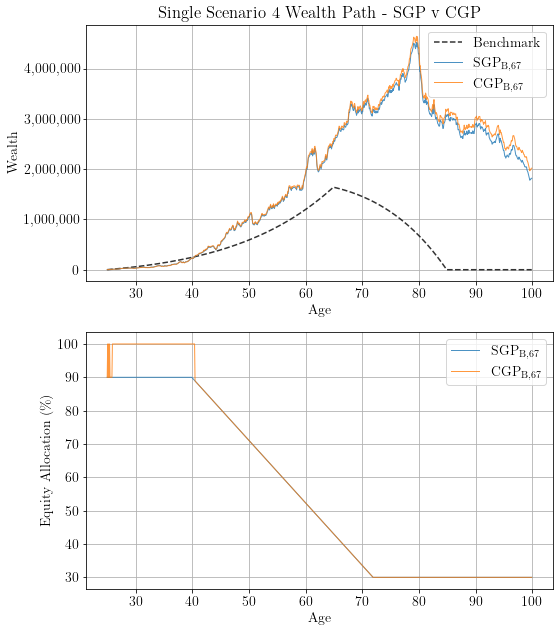

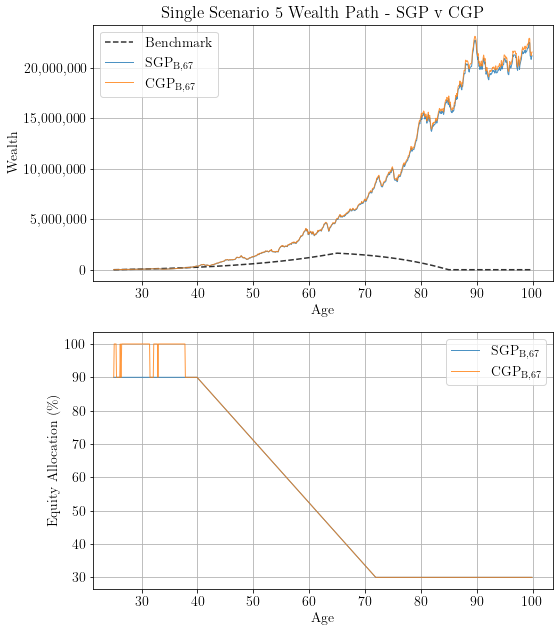

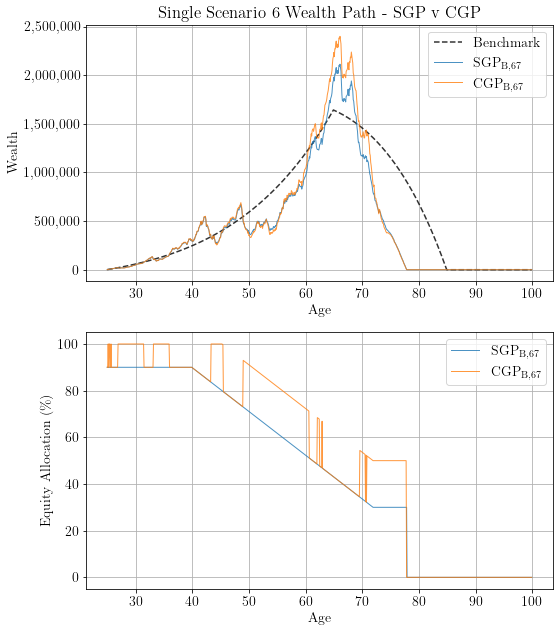

In [113]:
def plot_interesting_example(sim, title='Wealth Path for a Single Scenario', file_name = None):
    num_periods = 900
    xs = [25 + x/12 for x in range(num_periods)]

    fig = plt.figure(figsize=(8,9))

    ax1 = fig.add_subplot(2,1,1)    

    benchmark_wealth_path = np.load('numpy/bm_path.npy')
    ax1.plot(xs, benchmark_wealth_path,label='Benchmark',color='k',linestyle='--',alpha=0.8)
    
    ax1.plot(xs, np.sum(port_sgp.port_wealth[sim,1:],axis=1),linewidth=1,label='$\mathrm{SGP_{B,67}}$',alpha=0.8)
    ax1.plot(xs, np.sum(port_cgp.port_wealth[sim,1:],axis=1),linewidth=1,label='$\mathrm{CGP_{B,67}}$',alpha=0.8)
    #ax1.plot(xs, np.sum(port_pgp.port_wealth[sim,1:], axis=1), linewidth=1, label='$\mathrm{PGP_{B,67}}$', alpha=0.8)
    #ax1.plot(xs, np.sum(port_dzgp.port_wealth[sim,1:], axis=1), linewidth=1, label='$\mathrm{DZGP_{B,67}}$', alpha=0.8)

    
    ax1.set_ylabel('Wealth')
    ax1.set_xlabel('Age')
    ax1.set_title(title)
    ax1.legend()
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax1.grid()
    

    ax2 = fig.add_subplot(2,1,2)    

    ax2.plot(xs,100*np.sum(port_sgp.port_alloc[sim,:,0:2],axis=1),linewidth=1,label='$\mathrm{SGP_{B,67}}$',alpha=0.8)
    ax2.plot(xs,100*np.sum(port_cgp.port_alloc[sim,:,0:2],axis=1),linewidth=1,label='$\mathrm{CGP_{B,67}}$',alpha=0.8)
    #ax2.plot(xs,100*np.sum(port_pgp.port_alloc[sim,:,0:2],axis=1), linewidth=1, label='$\mathrm{PGP_{B,67}}$', alpha=0.8)
    #ax2.plot(xs,100*np.sum(port_dzgp.port_alloc[sim,:,0:2],axis=1), linewidth=1, label='$\mathrm{DZGP_{B,67}}$', alpha=0.8)

    ax2.set_ylabel('Equity Allocation (\%)')
    ax2.set_xlabel('Age')
    ax2.legend()
    ax2.grid()
    plt.tight_layout()
    if file_name != None:
        plt.savefig(file_name,dpi=300)
    plt.show()

plot_interesting_example(1,title='Single Scenario 1 Wealth Path - SGP v CGP',file_name='fig_1')
plot_interesting_example(2,title='Single Scenario 2 Wealth Path - SGP v CGP',file_name='fig_2')
plot_interesting_example(3,title='Single Scenario 3 Wealth Path - SGP v CGP',file_name='fig_3')
plot_interesting_example(4,title='Single Scenario 4 Wealth Path - SGP v CGP',file_name='fig_4')
plot_interesting_example(5,title='Single Scenario 5 Wealth Path - SGP v CGP',file_name='fig_5')
plot_interesting_example(6,title='Single Scenario 6 Wealth Path - SGP v CGP',file_name='fig_6')

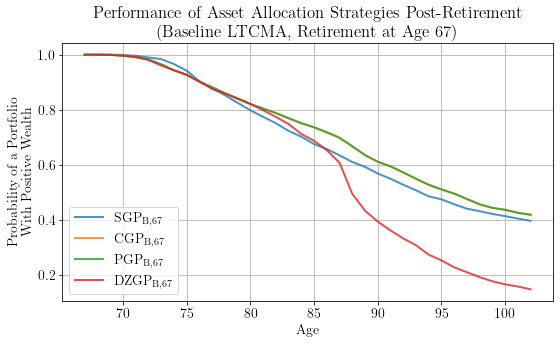

In [99]:
list_ports_baseline_67 = [port_sgp,port_cgp,port_pgp,port_dzgp] # port_cgp fix this
list_names_baseline_67 = ['$\\mathrm{' + port.descr + '}$' for port in list_ports_baseline_67]
Plotting.prob_success(list_ports_baseline_67,list_names_baseline_67,67, 102,figsize=(8,5),
                      title_extra='(Baseline LTCMA, Retirement at Age 67)',file_name='baseline_67_prob_success')

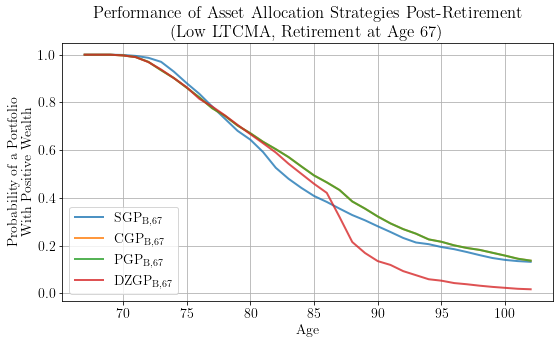

In [100]:
list_ports_low_67 = [port_sgp_low,port_cgp_low,port_pgp_low,port_dzgp_low] # port_cgp fix this
list_names_low_67 = ['$\\mathrm{' + port.descr + '}$' for port in list_ports_low_67]
Plotting.prob_success(list_ports_low_67,list_names_low_67,67, 102,figsize=(8,5),
                      title_extra='(Low LTCMA, Retirement at Age 67)',file_name='low_67_prob_success')

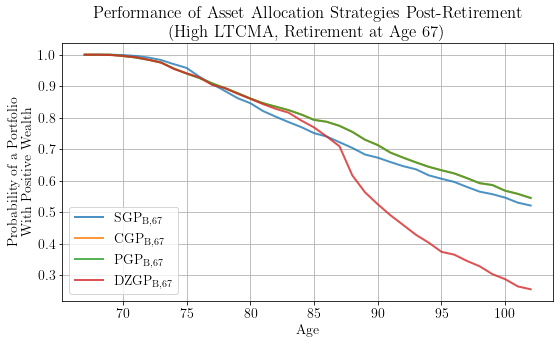

In [101]:
list_ports_high_67 = [port_sgp_high,port_cgp_high,port_pgp_high,port_dzgp_high] # port_cgp fix this
list_names_high_67 = ['$\\mathrm{' + port.descr + '}$' for port in list_ports_high_67]
Plotting.prob_success(list_ports_high_67,list_names_high_67,67, 102,figsize=(8,5),
                      title_extra='(High LTCMA, Retirement at Age 67)',file_name='high_67_prob_success')

## Generating sample benchmark wealth paths

### Create benchmark wealth path, retire at 67

In [102]:
benchmark_wealth_path = np.zeros(75*12)
salary = average_salary
annual_return = 0.05
benchmark_wealth_path[0] = salary*0.15/12
for i in range(1,75*12):
    if i < 40*12:
        benchmark_wealth_path[i] = benchmark_wealth_path[i-1]*(1+annual_return)**(1/12) + salary*0.15/12*1.022**(i/12)
    else:
        benchmark_wealth_path[i] = max(0,benchmark_wealth_path[i-1]*(1+annual_return)**(1/12) - salary*0.7/12*1.022**(i/12))
np.save('numpy/bm_path', benchmark_wealth_path)

### Create benchmark wealth path, retire at 72

In [103]:
benchmark_wealth_path_72 = np.zeros(75*12)
salary = average_salary
annual_return = 0.05
benchmark_wealth_path[0] = salary*0.15/12
for i in range(1,75*12):
    if i < 45*12:
        benchmark_wealth_path_72[i] = benchmark_wealth_path_72[i-1]*(1+annual_return)**(1/12) + salary*0.15/12*1.022**(i/12)
    else:
        benchmark_wealth_path_72[i] = max(0,benchmark_wealth_path_72[i-1]*(1+annual_return)**(1/12) - salary*0.7/12*1.022**(i/12))

np.save('numpy/bm_path_72', benchmark_wealth_path_72)

In [104]:
t = 3
print(benchmark_wealth_path[t-1])
print(np.sum(port_cgp_test.port_wealth[1,t,:],axis=0))

for i in range(75*12):
    print('age ', 25 + i/12, port_cgp_test.port_alloc[1,i,:])

2406.4280350061663
2510.9386081997513
age  25.0 [0.54 0.36 0.07 0.03]
age  25.083333333333332 [0.54 0.36 0.07 0.03]
age  25.166666666666668 [0.54 0.36 0.07 0.03]
age  25.25 [0.54 0.36 0.07 0.03]
age  25.333333333333332 [0.54 0.36 0.07 0.03]
age  25.416666666666668 [0.54 0.36 0.07 0.03]
age  25.5 [0.54 0.36 0.07 0.03]
age  25.583333333333332 [0.54 0.36 0.07 0.03]
age  25.666666666666668 [0.54 0.36 0.07 0.03]
age  25.75 [0.54 0.36 0.07 0.03]
age  25.833333333333332 [0.54 0.36 0.07 0.03]
age  25.916666666666668 [0.54 0.36 0.07 0.03]
age  26.0 [0.54 0.36 0.07 0.03]
age  26.083333333333332 [0.54 0.36 0.07 0.03]
age  26.166666666666668 [0.54 0.36 0.07 0.03]
age  26.25 [0.54 0.36 0.07 0.03]
age  26.333333333333332 [0.6 0.4 0.  0. ]
age  26.416666666666668 [0.6 0.4 0.  0. ]
age  26.5 [0.6 0.4 0.  0. ]
age  26.583333333333332 [0.6 0.4 0.  0. ]
age  26.666666666666668 [0.6 0.4 0.  0. ]
age  26.75 [0.6 0.4 0.  0. ]
age  26.833333333333332 [0.6 0.4 0.  0. ]
age  26.916666666666668 [0.6 0.4 0.  0. 

### Create figure for the benchmark wealth path

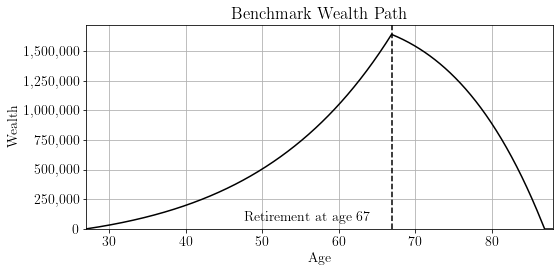

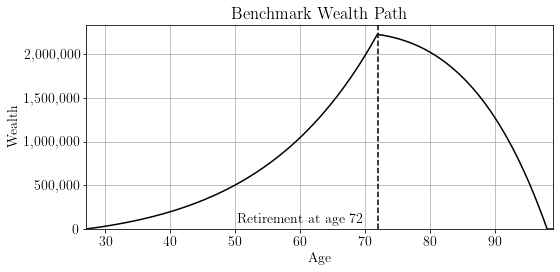

In [105]:
# create plot for the benchmark wealth path
def benchmark_plot(benchmark_wealth_path, retirement_age,xlim,filename=None):
    num_periods = 900

    fig,ax = plt.subplots(1,figsize=(8,4))
    ax.set_facecolor('white') # Set the face color to white
    plt.plot(figsize=(8,8))
    xs = [27 + x/12 for x in range(num_periods)]
    plt.plot(xs, benchmark_wealth_path, color='k')

    # mark retirement date
    plt.axvline(x=retirement_age,linestyle='--',color='k')
    plt.text(retirement_age - xlim[1]*0.22, average_salary, 'Retirement at age ' + str(retirement_age))

    plt.title('Benchmark Wealth Path')
    plt.ylabel('Wealth')
    plt.xlabel('Age')
    plt.ylim(0, plt.ylim()[1])
    plt.xlim(xlim)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.grid(True)
    plt.tight_layout()
    if filename != None:
        plt.savefig(filename,dpi=300)

    plt.show()

benchmark_plot(benchmark_wealth_path, 67,(27,88), filename='benchmark_wealth_path_67')
benchmark_plot(benchmark_wealth_path_72, 72,(27,99), filename='benchmark_wealth_path_72')

In [106]:
for i in range(75*12):
    print('age ', 27 + i/12, benchmark_wealth_path[i])

age  27.0 797.4391249999999
age  27.083333333333332 1599.5745498191457
age  27.166666666666668 2406.4280350061663
age  27.25 3218.021434533674
age  27.333333333333332 4034.376696187442
age  27.416666666666668 4855.51586195728
age  27.5 5681.461068429524
age  27.583333333333332 6512.23454718113
age  27.666666666666668 7347.858625175406
age  27.75 8188.355725159354
age  27.833333333333332 9033.74836606266
age  27.916666666666668 9884.059163398319
age  28.0 10739.310829664908
age  28.083333333333332 11599.526174750517
age  28.166666666666668 12464.728106338342
age  28.25 13334.939630313938
age  28.333333333333332 14210.183851174163
age  28.416666666666668 15090.483972437785
age  28.5 15975.863297057796
age  28.583333333333332 16866.34522783541
age  28.666666666666668 17761.953267835765
age  28.75 18662.711020805345
age  28.833333333333332 19568.642191591105
age  28.916666666666668 20479.770586561324
age  29.0 21396.120114028196
age  29.083333333333332 22317.71478467215
age  29.16666666666

Adapted from Chen (2019)